In [1]:
import pandas as pd
import numpy as np

def get_time_series_for_window(start_date, end_date, station, dataframe):
    return dataframe.loc[start_date:end_date, [station]]


def check_nan_values(dataframe):
    return dataframe.isnull().values.any()


def get_valid_sequences(df):
    valid_sequences = []
    starting_idx = 0

    for i, (_, row) in enumerate(df.iterrows()):
        flow = row[0]

        if np.isnan(flow):

            if starting_idx < i-1:
                valid_sequences.append((starting_idx, i))
                starting_idx = i+1
            else:
                starting_idx = i+1
                continue
    
    if not check_nan_values(df.iloc[starting_idx:, :]):
        valid_sequences.append((starting_idx, len(df)))
    return valid_sequences


def valid_seqs_minimum_len(valid_seqs, seq_len):
    
    valid_seqs_min_len = []
    pops = []
    for i, (start, end) in enumerate(valid_seqs):
        if end - start >= seq_len:
            valid_seqs_min_len.append((start, end))

    return valid_seqs_min_len



def split_sequences(possible_seqs, split_len):
    
    usable_seqs = []
    for seq in possible_seqs:
        usable_seqs += get_seq_splits(seq, split_len)
        
    return usable_seqs
        
        
        
def get_seq_splits(seq, split_len):
    
    start = seq[0]
    end = seq[1]
    
    chunks = (end - start) // (split_len+1)     # +1 because there must be an unobserved item after each chunk
                                                # which will be the y (after window value)

    splits = []
    prev_end_chunk = start
    for i in range(chunks):

        start_chunk = prev_end_chunk
        end_chunk = start_chunk + split_len
        splits.append((start_chunk, end_chunk))
        prev_end_chunk = end_chunk+1
        
    return splits


def get_seq_obs_values(seq, df):
    return np.array(df.iloc[seq[0]:seq[1], :]), np.array(df.iloc[seq[1], :])


def split_seqs_train_test(train_frac, usable_seqs):
    
    total_seqs = len(usable_seqs)
    train_amount = round(total_seqs * train_frac)
    
    random.shuffle(usable_seqs)
    train_seqs = usable_seqs[0:train_amount]
    test_seqs = usable_seqs[train_amount:]
    
    return train_seqs, test_seqs


def mount_trainable_testable_arrays(seqs, df):
    
    x_data = []
    y_data = []
    for seq in seqs:
        x, y = get_seq_obs_values(seq, df)
        x_data.append(x)
        y_data.append(y)
    
    return np.array(x_data), np.array(y_data)



def transform_cleb_df_into_wal_df(cleb_df):
    
    index_names = {}
    for i, (_, row) in enumerate(cleb_df.iterrows()):
        
        year = str(int(row[2]))
        month = str(int(row[1]))
        day = str(int(row[0]))
        hour = str(int(row[3]))
        index_name = year+'-'+month+'-'+day+'-'+hour
        
        index_names[i] = index_name
        
    
    cleb_df.rename(index=index_names)
    cleb_df = cleb_df.drop('day', 1)
    cleb_df = cleb_df.drop('month', 1)
    cleb_df = cleb_df.drop('year', 1)
    cleb_df = cleb_df.drop('hour', 1)
    return cleb_df.replace(-1, np.nan)





flow_path = "/home/colombelli/Documents/hydro-ml/data/Vazao.txt"
rain_path = "/home/colombelli/Documents/hydro-ml/data/Chuva.txt"
et_path = "/home/colombelli/Documents/hydro-ml/data/ET.txt"

flow_df = pd.read_csv(flow_path, sep="\t", header=None)
flow_df.columns = ["day", "month", "year", "hour", "flow"]

rain_df = pd.read_csv(rain_path, sep="\t", header=None)
rain_df.columns = ["day", "month", "year", "hour", "rain"]

et_df = pd.read_csv(et_path, sep="\t", header=None)
et_df.columns = ["day", "month", "year", "hour", "et"]


flow_df = transform_cleb_df_into_wal_df(flow_df)
rain_df = transform_cleb_df_into_wal_df(rain_df)
et_df = transform_cleb_df_into_wal_df(et_df)


# this fixed val_seq was extracted from the other notebook (no complete automation yet - just a poc)
val_seq = [(5962, 6051), (6078, 17486), (17487, 18718), (18741, 23437)]

In [6]:
import tensorflow as tf 

import os
import time
from IPython import display as ipythondisplay
from tqdm import tqdm

In [6]:
def LSTM(rnn_units): 
      return tf.keras.layers.LSTM(
        rnn_units, 
        return_sequences=True, 
        recurrent_initializer='glorot_uniform',
        recurrent_activation='sigmoid',
        stateful=True,
        dropout=0.3, 
        recurrent_dropout=0.3
      )


### Defining the RNN Model ###
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        # Layer 1: Embedding layer to transform indices into dense vectors 
        #   of a fixed embedding size
        tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

        # Layer 2: LSTM with `rnn_units` number of units. 
        LSTM(rnn_units),

        # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
        #   into the vocabulary size.
        tf.keras.layers.Dense(vocab_size)
      ])
    return model


### Defining the loss function ###
def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss


@tf.function
def train_step(x, y): 
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = compute_loss(y, y_hat)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [9]:
window = 30*24
np.array(flow_df.iloc[7000:7001+window])

array([[105.84],
       [107.3 ],
       [108.76],
       [109.86],
       [110.6 ],
       [111.34],
       [111.34],
       [111.34],
       [112.84],
       [113.97],
       [115.48],
       [117.4 ],
       [120.11],
       [122.86],
       [126.05],
       [129.7 ],
       [134.24],
       [138.45],
       [142.31],
       [145.79],
       [150.68],
       [155.66],
       [159.8 ],
       [164.01],
       [169.25],
       [175.09],
       [180.54],
       [186.61],
       [192.8 ],
       [199.12],
       [205.02],
       [211.02],
       [216.57],
       [222.22],
       [228.52],
       [237.34],
       [309.1 ],
       [480.25],
       [603.53],
       [619.39],
       [632.24],
       [646.36],
       [659.56],
       [675.17],
       [687.59],
       [702.44],
       [716.33],
       [729.21],
       [744.61],
       [756.59],
       [772.34],
       [785.82],
       [798.2 ],
       [811.96],
       [824.59],
       [837.33],
       [846.33],
       [855.39],
       [865.81

In [34]:
list(np.squeeze(np.array(flow_df.iloc[7000:7001+window])))

[105.84,
 107.3,
 108.76,
 109.86,
 110.6,
 111.34,
 111.34,
 111.34,
 112.84,
 113.97,
 115.48,
 117.4,
 120.11,
 122.86,
 126.05,
 129.7,
 134.24,
 138.45,
 142.31,
 145.79,
 150.68,
 155.66,
 159.8,
 164.01,
 169.25,
 175.09,
 180.54,
 186.61,
 192.8,
 199.12,
 205.02,
 211.02,
 216.57,
 222.22,
 228.52,
 237.34,
 309.1,
 480.25,
 603.53,
 619.39,
 632.24,
 646.36,
 659.56,
 675.17,
 687.59,
 702.44,
 716.33,
 729.21,
 744.61,
 756.59,
 772.34,
 785.82,
 798.2,
 811.96,
 824.59,
 837.33,
 846.33,
 855.39,
 865.81,
 872.36,
 877.63,
 884.24,
 889.54,
 890.87,
 892.2,
 896.2,
 896.2,
 892.2,
 890.87,
 886.89,
 885.56,
 880.26,
 874.99,
 871.05,
 867.12,
 860.59,
 855.39,
 850.21,
 843.75,
 837.33,
 832.22,
 825.85,
 816.99,
 810.7,
 801.93,
 794.47,
 785.82,
 777.22,
 768.68,
 758.99,
 748.19,
 737.47,
 728.03,
 715.16,
 702.44,
 692.13,
 677.42,
 664.0,
 650.74,
 633.33,
 622.58,
 608.78,
 595.19,
 582.79,
 569.54,
 559.48,
 556.48,
 556.48,
 556.48,
 556.48,
 555.49,
 552.5,
 550.52

In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [17]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
print(dataset)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

(5, 3, 2) (5, 2)
[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]]
[[10 15]
 [20 25]
 [30 35]] [ 85 105]
[[20 25]
 [30 35]
 [40 45]] [105 125]
[[30 35]
 [40 45]
 [50 55]] [125 145]
[[40 45]
 [50 55]
 [60 65]] [145 165]
[[50 55]
 [60 65]
 [70 75]] [165 185]


In [18]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [22]:
dataset = pd.concat([flow_df, rain_df, et_df, flow_df], axis=1)
dataset.columns = ['flow', 'rain', 'et', 'y']

In [23]:
dataset

,flow,rain,et,y
0,159.80,3.6,0.0555,159.80
1,158.41,2.6,0.0555,158.41
2,157.49,1.0,0.0555,157.49
3,156.11,1.2,0.0555,156.11
4,154.28,5.6,0.0555,154.28
...,...,...,...,...
25949,183.05,0.0,0.1480,183.05
25950,181.04,0.0,0.1480,181.04
25951,181.04,0.0,0.1480,181.04
25952,181.04,0.0,0.1480,181.04


In [30]:
# window without NA (17487, 18718) after that i could try (6078, 17486)
to_split = np.array(dataset.iloc[17487:18718, ])

In [43]:
n_steps_in = 24*30   #24 hours, 30 days
n_steps_out = 24*7   #24 hours, 7 days

X, y = split_sequences(to_split, n_steps_in, n_steps_out)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [51]:
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(128, activation='sigmoid', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(128, activation='sigmoid'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [52]:
# fit model
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
11/11 [==============================] - 8s 745ms/step - loss: 1917.8132
Epoch 2/200
11/11 [==============================] - 8s 757ms/step - loss: 1811.3824
Epoch 3/200
11/11 [==============================] - 8s 760ms/step - loss: 1673.3735
Epoch 4/200
11/11 [==============================] - 9s 814ms/step - loss: 1534.2856
Epoch 5/200
11/11 [==============================] - 9s 825ms/step - loss: 1410.4071
Epoch 6/200
11/11 [==============================] - 9s 835ms/step - loss: 1294.5298
Epoch 7/200
11/11 [==============================] - 9s 824ms/step - loss: 1188.9178
Epoch 8/200
11/11 [==============================] - 9s 817ms/step - loss: 1091.3947
Epoch 9/200
11/11 [==============================] - 9s 834ms/step - loss: 1002.6118
Epoch 10/200
11/11 [==============================] - 9s 816ms/step - loss: 916.4674
Epoch 11/200
11/11 [==============================] - 9s 826ms/step - loss: 839.6967
Epoch 12/200
11/11 [==============================] - 9s 810ms/st

KeyboardInterrupt: 

In [56]:
x_input = np.array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, 3, 2))
x_input

array([[[70, 75],
        [80, 85],
        [90, 95]]])

In [75]:
dataset.iloc[0:5, 3:4]

,y
0,159.80
1,158.41
2,157.49
3,156.11
4,154.28


In [72]:
x_test = np.array(dataset.iloc[18741:23437, 0:3])

In [76]:
y_test = np.array(dataset.iloc[18741:23437, 3:4])

In [83]:
x_test = x_test[0:n_steps_in].reshape((1, n_steps_in, n_features))

In [97]:
yhat = model.predict(x_test, verbose=0)
len(yhat[0])

168

In [111]:
y_test = y_test[n_steps_in:n_steps_in+n_steps_out]

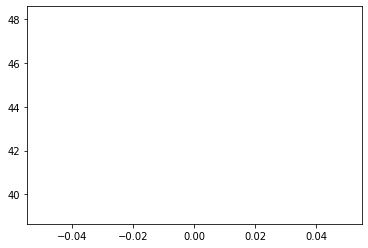

In [102]:
import matplotlib.pyplot as plt

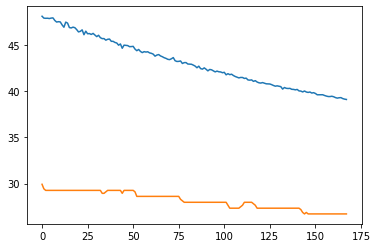

In [113]:
plt.plot(yhat[0])
plt.plot(y_test)